# **CT: Computerized Tomography Scan Diagnosis**
### **Abdallah Fekry**
**Model 14**

---

class 0 = Cyst

class 1 = Normal

class 2 = Stone

class 3 = Tumor

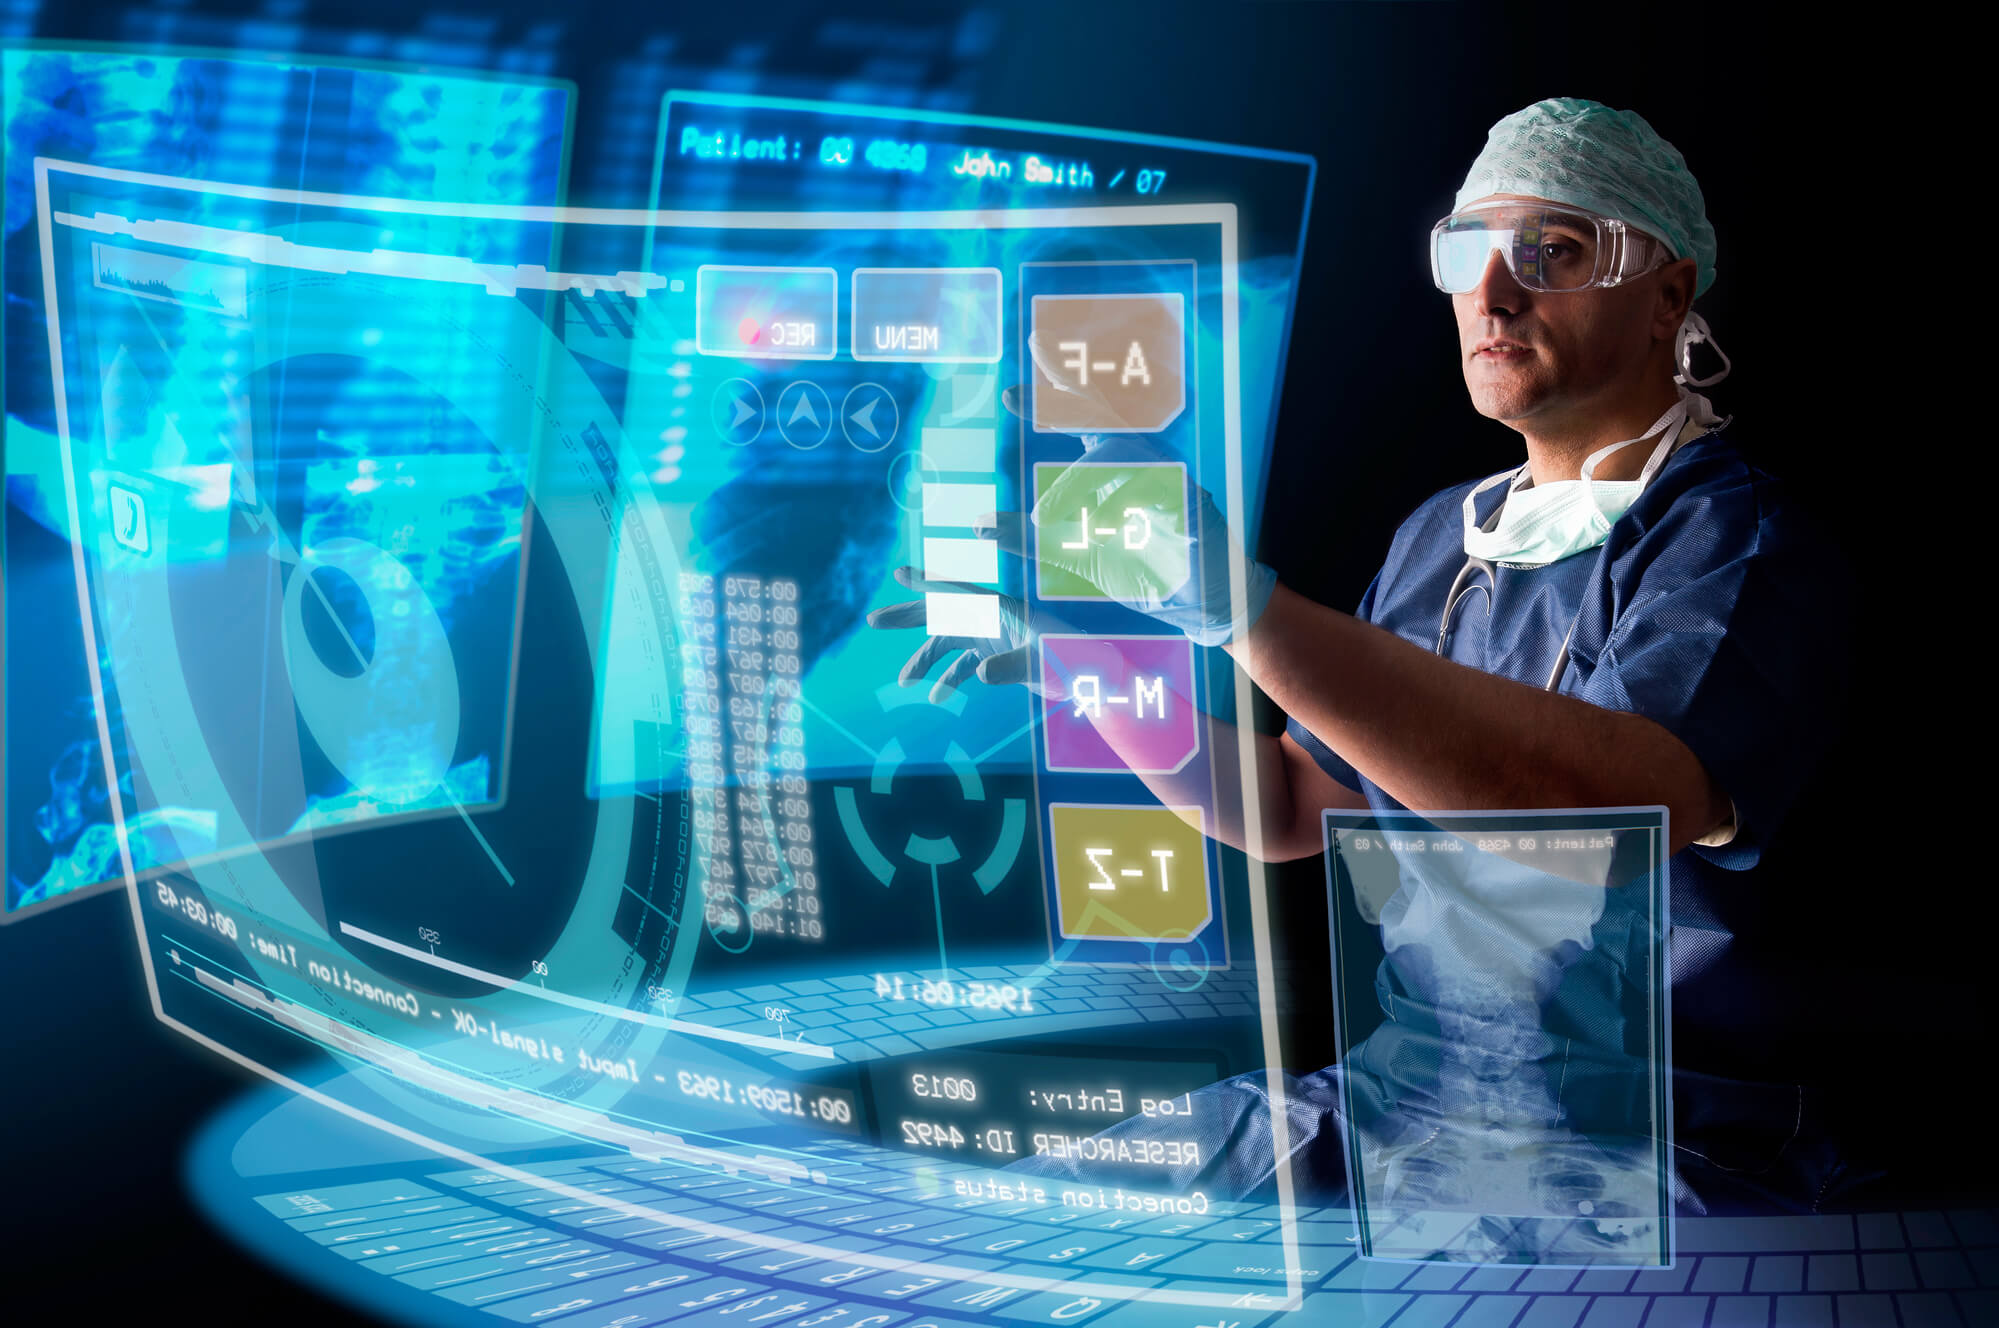

In [1]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
import keras
keras.__version__

'2.15.0'

In [1]:
classes = {0 : 'Cyst',
           1 : 'Normal',
           2 : 'Stone',
           3 : 'Tumor'}

In [2]:
classes[0]

'Cyst'

---

importing libraries

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from sklearn.metrics import confusion_matrix

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_data = train_datagen.flow_from_directory('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')
test_data = train_datagen.flow_from_directory('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False,
                                              subset='validation')

Found 11204 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [15]:
test_data.labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [16]:
train_data.image_shape

(224, 224, 3)

In [17]:
np.unique(test_data.labels)

array([0, 1, 2, 3], dtype=int32)

In [18]:
train_data.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

# Model VGG 16 Arcitecture

In [32]:
vgg16_model = vgg16.VGG16(include_top=False, input_shape=(224,224,3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
for layer in vgg16_model.layers[:]:
  layer.trainable = False
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_13 (Dense)            (None, 4096)              16781312  
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_14 (Dense)            (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 

In [23]:
len(train_data.labels)

11204

In [35]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

results = model.fit(train_data, epochs=30, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks=EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
                  )

Epoch 1/30
351/351 [==============================] - 65s 180ms/step - loss: 0.6317 - accuracy: 0.9153 - val_loss: 1.0231 - val_accuracy: 0.7955
Epoch 2/30
351/351 [==============================] - 62s 176ms/step - loss: 0.0669 - accuracy: 0.9808 - val_loss: 2.1318 - val_accuracy: 0.6176
Epoch 3/30
351/351 [==============================] - 67s 190ms/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.6946 - val_accuracy: 0.8462
Epoch 4/30
351/351 [==============================] - 67s 190ms/step - loss: 7.9624e-05 - accuracy: 1.0000 - val_loss: 0.7245 - val_accuracy: 0.8551
Epoch 5/30
351/351 [==============================] - 67s 191ms/step - loss: 3.3021e-05 - accuracy: 1.0000 - val_loss: 0.7337 - val_accuracy: 0.8631
Epoch 6/30
351/351 [==============================] - 66s 187ms/step - loss: 2.6146e-05 - accuracy: 1.0000 - val_loss: 0.7727 - val_accuracy: 0.8631
Epoch 7/30
351/351 [==============================] - 64s 182ms/step - loss: 2.0033e-05 - accuracy: 1.0000 - val_loss:

In [37]:
model2 = model

### Retrain the model

In [38]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

results2 = model2.fit(train_data, epochs=30, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks=EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
                  )

Epoch 1/30
351/351 [==============================] - 61s 170ms/step - loss: 0.0364 - accuracy: 0.9906 - val_loss: 0.9984 - val_accuracy: 0.8140
Epoch 2/30
351/351 [==============================] - 60s 171ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.8617 - val_accuracy: 0.8712
Epoch 3/30
351/351 [==============================] - 60s 171ms/step - loss: 5.0324e-06 - accuracy: 1.0000 - val_loss: 0.8517 - val_accuracy: 0.8849
Epoch 4/30
351/351 [==============================] - 61s 174ms/step - loss: 3.2825e-06 - accuracy: 1.0000 - val_loss: 0.8471 - val_accuracy: 0.8945
Epoch 5/30
351/351 [==============================] - 60s 170ms/step - loss: 1.5915e-06 - accuracy: 1.0000 - val_loss: 0.8439 - val_accuracy: 0.8929
Epoch 6/30
351/351 [==============================] - 60s 169ms/step - loss: 1.3191e-06 - accuracy: 1.0000 - val_loss: 0.8726 - val_accuracy: 0.8961
Epoch 7/30
351/351 [==============================] - 60s 172ms/step - loss: 9.3592e-07 - accuracy: 1.0000 - val_l

In [50]:
loss, acc = model2.evaluate(test_data)

39/39 [==============================] - 6s 146ms/step - loss: 0.8858 - accuracy: 0.8986


In [51]:
print('Test accuracy = ',round(acc*100,2),'%\nLoss = ',loss ,sep='')

Test accuracy = 89.86%
Loss = 0.8858487010002136


In [52]:
results2.history['val_loss']

[0.9984153509140015,
 0.8616594672203064,
 0.851656436920166,
 0.8470798134803772,
 0.8439044952392578,
 0.8725996017456055,
 0.8858487010002136,
 0.9093016386032104,
 0.955686092376709,
 0.9577165246009827,
 0.9802321791648865,
 1.0149115324020386]

In [53]:
results2.history['val_accuracy']

[0.8140096664428711,
 0.8711755275726318,
 0.8848631381988525,
 0.8945249319076538,
 0.8929146528244019,
 0.8961352705955505,
 0.8985507488250732,
 0.8977455496788025,
 0.8945249319076538,
 0.8913043737411499,
 0.8961352705955505,
 0.8929146528244019]

In [54]:
i = results2.history['val_accuracy'].index(acc)
i

6

In [55]:
results2.history['val_accuracy'][i]

0.8985507488250732

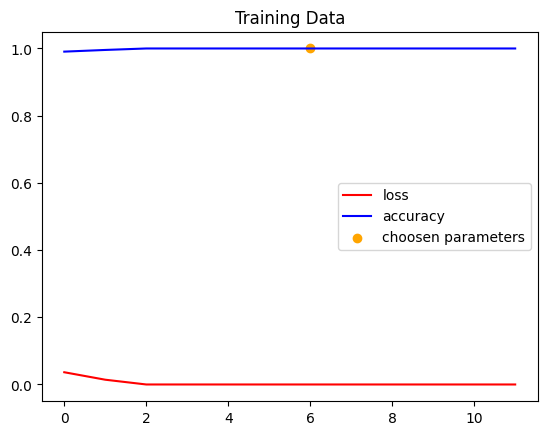

In [56]:
fig = plt.figure()
plt.plot(results2.history['loss'], c='red', label='loss')
plt.plot(results2.history['accuracy'], c='blue', label='accuracy')
plt.scatter(i ,results2.history['accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Training Data")
plt.legend(loc="center right")
plt.show()

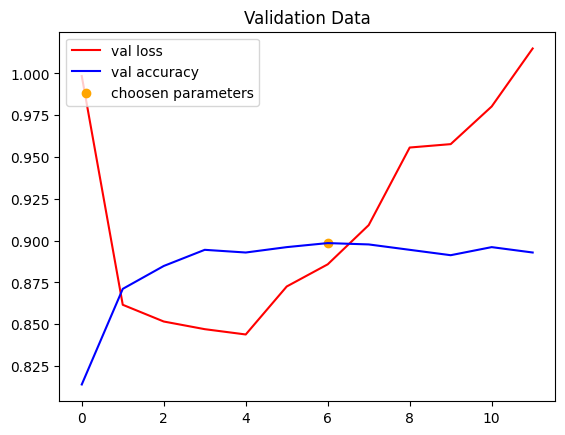

In [57]:
fig = plt.figure()
plt.plot(results2.history['val_loss'], c='red', label='val loss')
plt.plot(results2.history['val_accuracy'], c='blue', label='val accuracy')
plt.scatter(i ,results2.history['val_accuracy'][i], c='orange', label='choosen parameters', marker='o')
plt.title("Validation Data")
plt.legend(loc="upper left")
plt.show()

---

# Model: Dense Net 201 Arcitecture
(Best accuracy)

In [104]:
from keras.applications.densenet import DenseNet201
new_input = Input(shape=(224, 224, 3))
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=new_input)
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [105]:
for layer in base_model.layers[:]:
  layer.trainable = False
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [67]:
model3 = Sequential()
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(1000, activation='relu'))
model3.add(Dense(1000, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_5 (Flatten)         (None, 94080)             0         
                                                                 
 dense_15 (Dense)            (None, 1000)              94081000  
                                                                 
 dense_16 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_17 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 113407988 (432.62 MB)
Trainable params: 95086004 (362.72 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


In [69]:
from keras.optimizers import Adam
model3.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
results3 = model3.fit(train_data, epochs=50, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=5, monitor='val_accuracy',restore_best_weights=True)
                  )

Epoch 1/50
351/351 [==============================] - 99s 229ms/step - loss: 1.7269 - accuracy: 0.9169 - val_loss: 0.7394 - val_accuracy: 0.8301
Epoch 2/50
351/351 [==============================] - 65s 186ms/step - loss: 0.0557 - accuracy: 0.9877 - val_loss: 0.5682 - val_accuracy: 0.8551
Epoch 3/50
351/351 [==============================] - 65s 184ms/step - loss: 0.0803 - accuracy: 0.9812 - val_loss: 1.2281 - val_accuracy: 0.8180
Epoch 4/50
351/351 [==============================] - 65s 185ms/step - loss: 0.0310 - accuracy: 0.9914 - val_loss: 1.8530 - val_accuracy: 0.7085
Epoch 5/50
351/351 [==============================] - 65s 186ms/step - loss: 0.1790 - accuracy: 0.9760 - val_loss: 1.1887 - val_accuracy: 0.8873
Epoch 6/50
351/351 [==============================] - 65s 185ms/step - loss: 0.0190 - accuracy: 0.9967 - val_loss: 1.4425 - val_accuracy: 0.8502
Epoch 7/50
351/351 [==============================] - 66s 186ms/step - loss: 0.0275 - accuracy: 0.9952 - val_loss: 0.9338 - val_ac

In [70]:
loss3, acc3 = model3.evaluate(test_data)

39/39 [==============================] - 6s 156ms/step - loss: 0.7585 - accuracy: 0.9332


In [71]:
print("Test Accuracy:",round(acc3*100,2),"%","\nTest Loss:",loss3)

Test Accuracy: 93.32 % 
Test Loss: 0.7585238814353943


In [72]:
results3.history['val_accuracy']

[0.8301126956939697,
 0.8550724387168884,
 0.8180354237556458,
 0.7085345983505249,
 0.8872785568237305,
 0.8502415418624878,
 0.8913043737411499,
 0.9001610279083252,
 0.7890499234199524,
 0.8985507488250732,
 0.9323671460151672,
 0.9323671460151672,
 0.9331722855567932,
 0.9323671460151672,
 0.9323671460151672,
 0.9323671460151672,
 0.9323671460151672,
 0.9323671460151672]

In [73]:
results3.history['val_loss']

[0.7394343614578247,
 0.568170428276062,
 1.2280553579330444,
 1.8529788255691528,
 1.1887441873550415,
 1.4424935579299927,
 0.9338388442993164,
 1.2890931367874146,
 3.5261261463165283,
 0.8289493322372437,
 0.7597166299819946,
 0.7591556310653687,
 0.7585238814353943,
 0.7577657103538513,
 0.7567799687385559,
 0.7557438015937805,
 0.7545927166938782,
 0.7533785104751587]

In [74]:
i = results3.history['val_loss'].index(loss3)
i

12

In [75]:
results3.history['val_accuracy'][i]

0.9331722855567932

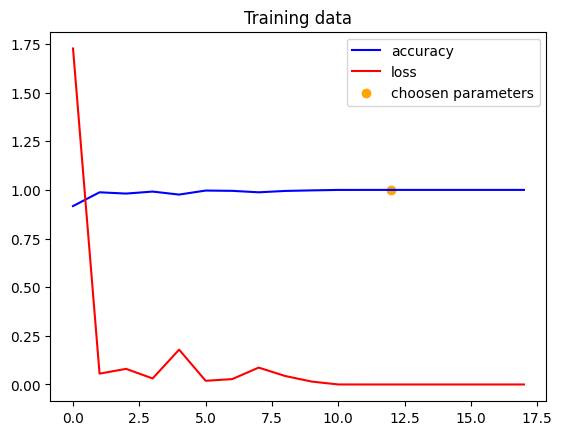

In [76]:
fig = plt.figure()
plt.plot(results3.history['accuracy'], c='blue', label='accuracy')
plt.plot(results3.history['loss'], c='red', label='loss')
plt.scatter(i,results3.history['accuracy'][i], c='orange', marker='o', label='choosen parameters')
plt.title('Training data')
plt.legend(loc='upper right')
plt.show()

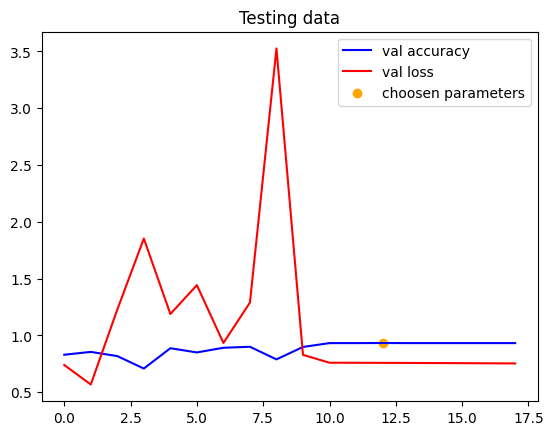

In [77]:
fig = plt.figure()
plt.plot(results3.history['val_accuracy'], c='blue', label='val accuracy')
plt.plot(results3.history['val_loss'], c='red', label='val loss')
plt.scatter(i,results3.history['val_accuracy'][i], c='orange', marker='o', label='choosen parameters')
plt.title('Testing data')
plt.legend(loc='upper right')
plt.show()

---

In [78]:
yp = model3.predict(test_data)
yp

39/39 [==============================] - 9s 149ms/step


array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 1.7720439e-27, 2.9814916e-35],
       [1.0000000e+00, 4.7401937e-26, 6.6868570e-20, 4.4420427e-25],
       ...,
       [5.0005973e-09, 4.6950613e-14, 1.5492265e-11, 1.0000000e+00],
       [1.3935068e-11, 4.1441378e-17, 3.5867568e-15, 1.0000000e+00],
       [3.2197817e-11, 1.0715753e-15, 2.1329358e-12, 1.0000000e+00]],
      dtype=float32)

In [79]:
yp = yp.argmax(axis=1)
yp

array([0, 0, 0, ..., 3, 3, 3])

In [80]:
yp.shape

(1242,)

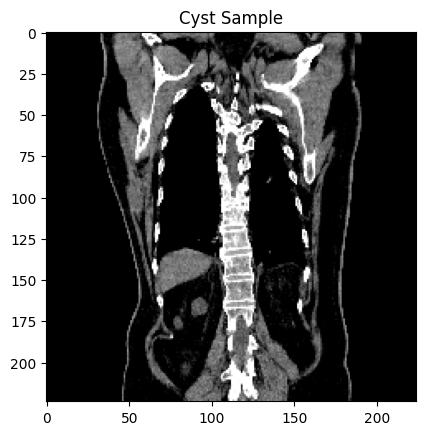

In [88]:
c = load_img('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg',target_size=(224,224))
plt.imshow(c)
plt.title('Cyst Sample')
plt.show()

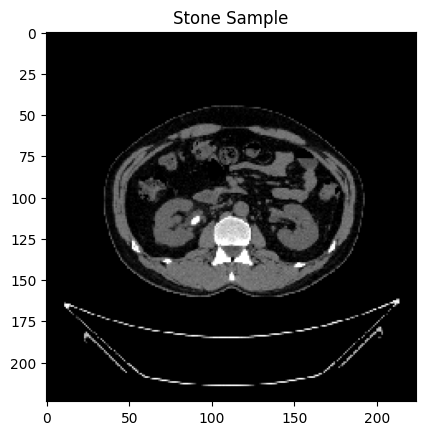

In [89]:
s = load_img('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1).jpg',target_size=(224,224))
plt.imshow(s)
plt.title('Stone Sample')
plt.show()

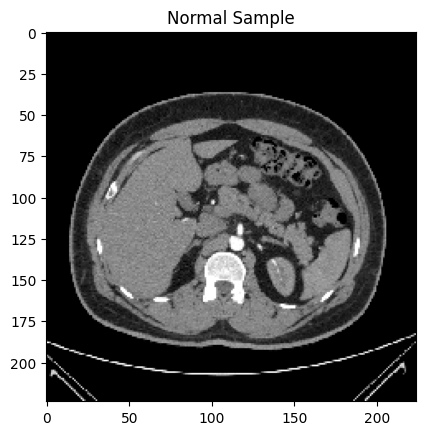

In [90]:
n = load_img('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1).jpg',target_size=(224,224))
plt.imshow(n)
plt.title('Normal Sample')
plt.show()

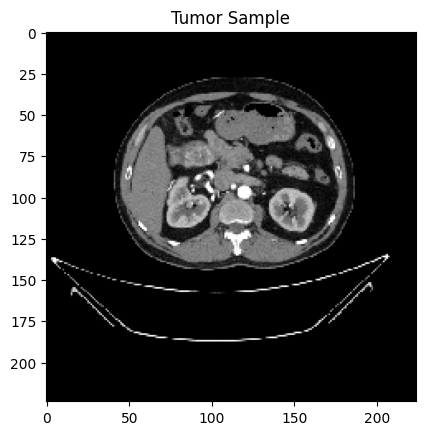

In [91]:
t = load_img('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (10).jpg',target_size=(224,224))
plt.imshow(t)
plt.title('Tumor Sample')
plt.show()

Text(0.5, 1.0, 'Tumor')

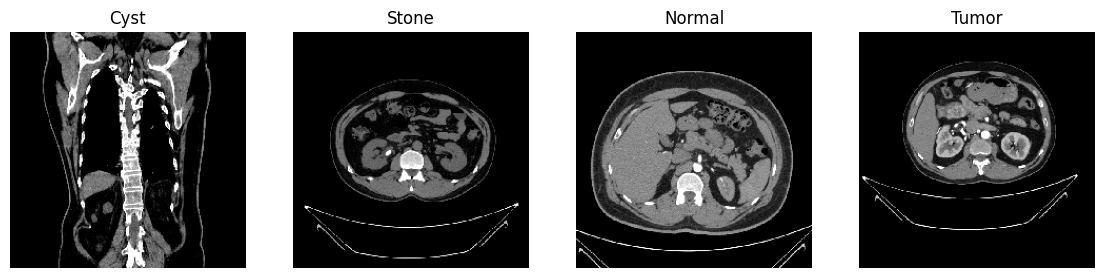

In [92]:
fig = plt.figure(figsize=(14,7))
# plt.grid=False
fig.add_subplot(1, 4, 1)
plt.axis('off')
plt.imshow(c)
plt.title('Cyst')
# _______________________________
fig.add_subplot(1, 4, 2)
plt.axis('off')
plt.imshow(s)
plt.title('Stone')
# _______________________________
fig.add_subplot(1, 4, 3)
plt.axis('off')
plt.imshow(n)
plt.title('Normal')
# _______________________________
fig.add_subplot(1, 4, 4)
plt.axis('off')
plt.imshow(t)
plt.title('Tumor')

In [93]:
c = img_to_array(c)
n = img_to_array(n)
s = img_to_array(s)
t = img_to_array(t)
c = c/255
n = n/255
s = s/255
t = t/255
c = c.reshape(1,224,224,3)
n = n.reshape(1,224,224,3)
s = s.reshape(1,224,224,3)
t = t.reshape(1,224,224,3)
t.shape

(1, 224, 224, 3)

In [94]:
p1 = model3.predict(c).argmax()
print("Actual: Cyst")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 7s 7s/step
Actual: Cyst
Predicted: Class 0: Cyst


In [95]:
p1 = model3.predict(s).argmax()
print("Actual: Stone")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 40ms/step
Actual: Stone
Predicted: Class 2: Stone


In [96]:
p1 = model3.predict(n).argmax()
print("Actual: Normal")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 37ms/step
Actual: Normal
Predicted: Class 1: Normal


In [97]:
p1 = model3.predict(t).argmax()
print("Actual: Tumor")
print("Predicted: Class ",p1,": ",classes[p1],sep='')

1/1 [==============================] - 0s 36ms/step
Actual: Tumor
Predicted: Class 3: Tumor


In [98]:
df = pd.DataFrame({'filename':test_data.filenames,'y_actual':test_data.classes,'Y_pred':yp})
df

,filename,y_actual,Y_pred
0,Cyst/Cyst- (1).jpg,0,0
1,Cyst/Cyst- (10).jpg,0,0
2,Cyst/Cyst- (100).jpg,0,0
3,Cyst/Cyst- (1000).jpg,0,0
4,Cyst/Cyst- (1001).jpg,0,0
...,...,...,...
1237,Tumor/Tumor- (12).jpg,3,3
1238,Tumor/Tumor- (120).jpg,3,3
1239,Tumor/Tumor- (1200).jpg,3,3
1240,Tumor/Tumor- (1201).jpg,3,3


In [99]:
test_data.labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [100]:
m = confusion_matrix(test_data.labels,yp)
m

array([[367,   0,   3,   0],
       [  1, 494,   0,  12],
       [  9,  10, 116,   2],
       [ 46,   0,   0, 182]])

Heatmap



<Axes: xlabel='Predicted', ylabel='Actual'>

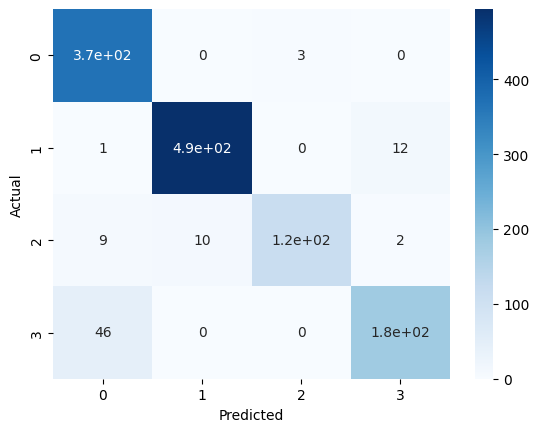

In [112]:
print("Heatmap\n")
m = pd.crosstab(test_data.labels, yp, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(m,annot=True, cmap='Blues')

---

In [102]:
model3.save('ct_scan_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'ct_scan_model.h5')

/kaggle/working


/kaggle/working/ct_scan_model.h5